# My Model
#### This model will use NMF on the cell line x drug df to create latent vectors of each that will be used as features in a tensorflow predictor

In [14]:
import sys, os
import pandas as pd
import numpy as np
import optuna
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer  # Import SimpleImputer for imputation
from sklearn.metrics import ndcg_score
from cadrres_sc import pp, utility


scriptpath = '..'
sys.path.append(os.path.abspath(scriptpath))

from cadrres_sc import evaluation

## Read DF and create latent vectors

### Make Latent Vectors
Use hyperparams from running optuna study in latent_model.py

In [23]:
df_path = '../data/GDSC/gdsc_all_abs_ic50_bayesian_sigmoid_only9dosages.csv'
df = pd.read_csv(df_path)
cell_line_obs_df = pd.read_csv(df_path, index_col=0)

cell_line_sample_list = cell_line_obs_df.index
drug_list = cell_line_obs_df.columns.tolist()


Impute missing values and factorize

In [ ]:
imputer = SimpleImputer(strategy='mean')
cell_line_obs_df_imputed = imputer.fit_transform(cell_line_obs_df)

# Apply Truncated SVD for matrix factorization
svd = TruncatedSVD(n_components=6)
latent_matrix = svd.fit_transform(cell_line_obs_df_imputed)


Split cell lines into train and test lists

In [ ]:

# Split cell lines into training and testing sets
frac_test = 0.2
cell_lines_train, cell_lines_test = train_test_split(cell_line_sample_list, test_size=frac_test, random_state=0)

# Prepare features and targets for training (grouped by cell line)
train_features = []
train_targets = []

test_features = []
test_targets = []


Build Train x/y using latent vectors for cell lines in train set and each drug

In [ ]:

# Loop over training cell lines
for cell_line in cell_lines_train:
    for drug in drug_list:
        # Get the latent vector for the current cell line (from SVD)
        cell_line_latent = latent_matrix[cell_line_obs_df.index.get_loc(cell_line)]
        # Get the latent vector for the current drug (from SVD)
        drug_latent = svd.components_[:, cell_line_obs_df.columns.get_loc(drug)]
        
        feature_vector = np.concatenate([cell_line_latent, drug_latent])
        ic50_value = cell_line_obs_df_imputed[cell_line_obs_df.index.get_loc(cell_line), cell_line_obs_df.columns.get_loc(drug)]
        train_features.append(feature_vector)
        train_targets.append(ic50_value)



Do same for Test


In [ ]:
for cell_line in cell_lines_test:
    for drug in drug_list:
        # Get the latent vector for the current cell line (from SVD)
        cell_line_latent = latent_matrix[cell_line_obs_df.index.get_loc(cell_line)]
        # Get the latent vector for the current drug (from SVD)
        drug_latent = svd.components_[:, cell_line_obs_df.columns.get_loc(drug)]
        
        feature_vector = np.concatenate([cell_line_latent, drug_latent])
        ic50_value = cell_line_obs_df_imputed[cell_line_obs_df.index.get_loc(cell_line), cell_line_obs_df.columns.get_loc(drug)]
        test_features.append(feature_vector)
        test_targets.append(ic50_value)


Convert the feature list and target list to numpy arrays


In [ ]:
train_features = np.array(train_features)
train_targets = np.array(train_targets)

test_features = np.array(test_features)
test_targets = np.array(test_targets)

### Train / Predict model
still using hyperparameters from optuna study

In [24]:
# Build the neural network model
hidden_units = 160
learning_rate = 0.0009647420370192299

model = keras.Sequential([
    layers.InputLayer(input_shape=(train_features.shape[1],)),
    layers.Dense(hidden_units, activation='relu'),
    layers.Dense(1)  # Single output unit for predicting IC50 value
])

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
              loss='mse',
              metrics=['mae'])

# Train the model
model.fit(train_features, train_targets, epochs=10, batch_size=32, validation_data=(test_features, test_targets), verbose=0)

# Predict IC50 values for the test set
y_pred = model.predict(test_features)

# Reshape y_test and y_pred to group by cell lines (num_cell_lines, num_drugs)
y_test_reshaped = test_targets.reshape(-1, len(drug_list))
y_pred_reshaped = y_pred.reshape(-1, len(drug_list))

1519/1519 [==============================] - 1s 806us/step


## Map Gene Expression Data to Pharmacogenomic Space
use test data to train a mapping from gene expression data to the latent space we trained our predictor on, to evaluate on unseen patients

In [ ]:
gene_exp_df = pd.read_csv('../data/GDSC/GDSC_exp.tsv', sep='\t', index_col=0)
print("Dataframe shape:", gene_exp_df.shape, "\n")
gene_exp_df.columns

If there is any gene with mutiple probes, calculate the mean.

In [ ]:
gene_exp_df = gene_exp_df.groupby(gene_exp_df.index).mean()
print("Dataframe shape:", gene_exp_df.shape, "\n")
gene_exp_df.items

### Normalize gene expression
We normalized baseline gene expression values for each gene by computing fold-changes compared to the average value across cell-lines

In [ ]:
cell_line_log2_mean_fc_exp_df, cell_line_mean_exp_df = pp.gexp.normalize_log2_mean_fc(gene_exp_df)
cell_line_log2_mean_fc_exp_df.head(5)

### Read essential genes list

In [ ]:
ess_gene_list = utility.read_first_column('..\data\IntOGen-DriverGenes.tsv')
print(len(ess_gene_list))

### Sample with both expression and response data

In [ ]:
cell_line_sample_list = np.array([s for s in cell_line_sample_list if s in gene_exp_df.columns])
len(cell_line_sample_list)

cell_line_log2_mean_fc_exp_df = cell_line_log2_mean_fc_exp_df[cell_line_sample_list]
cell_line_obs_df = cell_line_obs_df.loc[cell_line_sample_list, dataset_drug_list]
dataset_drug_df = dataset_drug_df.loc[dataset_drug_list]

cell_line_log2_mean_fc_exp_df.shape, cell_line_obs_df.shape, dataset_drug_df.shape

### Train Model to map from gene expression to pharmacogenomic space using test data

### Evaluate

# Prediction Evaluation
Using Spearman correlation and NDCG to evaluate performance

In [25]:
# Initialize a list to store the NDCG scores for each cell line
ndcg_scores = []

# Calculate NDCG for each cell line
for i in range(len(cell_lines_test)):
    true_ranking = np.argsort(y_test_reshaped[i])  # Ideal ranking based on true IC50 values (ascending order of IC50)
    predicted_ranking = np.argsort(y_pred_reshaped[i])  # Predicted ranking based on predicted IC50 values (ascending order of IC50)
    
    # Create relevance scores based on the rankings (higher rank = more relevant)
    true_relevance = np.zeros_like(y_test_reshaped[i])
    true_relevance[true_ranking] = np.arange(1, len(drug_list) + 1)  # Relevance assigned by rank (1 for most relevant)
    
    predicted_relevance = np.zeros_like(y_pred_reshaped[i])
    predicted_relevance[predicted_ranking] = np.arange(1, len(drug_list) + 1)  # Relevance based on predicted rank
    
    # Calculate NDCG for the current cell line
    ndcg_score_for_cell_line = ndcg_score([true_relevance], [predicted_relevance])
    ndcg_scores.append(ndcg_score_for_cell_line)

# Calculate the average NDCG score across all cell lines
average_ndcg = np.mean(ndcg_scores)
print(f"Average NDCG: {average_ndcg:.4f}")

Average NDCG: 0.9785


### Drug Latent Feature Similarity vs Fingerprint Similarity

In [26]:
from rdkit import Chem
from rdkit.Chem import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
import requests
import time

cid_to_smiles_cache = {}

def get_smiles_from_cid(cid):
    """Retrieve the SMILES string for a given PubChem Compound ID (CID)."""
    if cid in cid_to_smiles_cache:
        return cid_to_smiles_cache[cid]
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/property/CanonicalSMILES/JSON"
    response = requests.get(url)
    time.sleep(0.1)
    if response.status_code == 200:
        data = response.json()
        properties = data.get("PropertyTable", {}).get("Properties", [])
        if properties:
            smiles = properties[0].get("CanonicalSMILES")
            cid_to_smiles_cache[cid] = smiles
            return smiles
    raise ValueError(f"SMILES not found for CID {cid}.")

def compute_fp_similarity_from_cid(cid1, cid2):
    """Compute fingerprint similarity between two compounds using PubChem CIDs."""
    if not str(cid1).isdigit() or not str(cid2).isdigit():
        return 0
    try:
        # Get SMILES strings for the CIDs
        smiles1 = get_smiles_from_cid(cid1)
        smiles2 = get_smiles_from_cid(cid2)
    
        # Convert SMILES to RDKit Molecules
        mol1 = Chem.MolFromSmiles(smiles1)
        mol2 = Chem.MolFromSmiles(smiles2)
    
        if not mol1 or not mol2:
            raise ValueError("Could not parse SMILES into valid molecules.")
    
        # Compute fingerprints
        fp1 = FingerprintMols.FingerprintMol(mol1)
        fp2 = FingerprintMols.FingerprintMol(mol2)
    
        # Compute similarity
        similarity = DataStructs.FingerprintSimilarity(fp1, fp2)
        return similarity
    except Exception as e:
        print(f"Error computing similarity for CIDs {cid1} and {cid2}: {e}")
        return 0


##### Fingerprint Similarity Counts

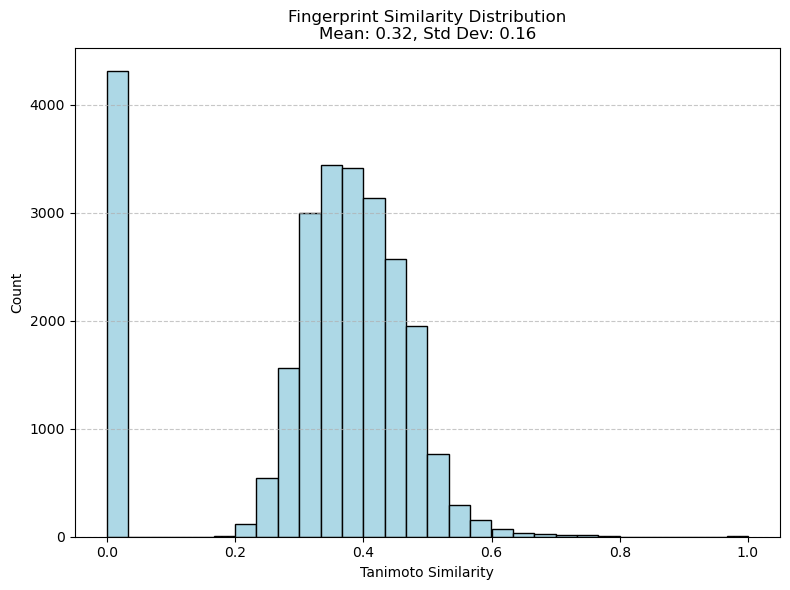

Average Tanimoto similarity: 0.3238567400130435
Standard deviation of Tanimoto similarity: 0.16182750742100038


In [27]:
import matplotlib.pyplot as plt
from itertools import combinations

dataset_drug_df = pd.read_csv('../preprocessed_data/GDSC/drug_stat.csv', index_col=0) # hn_drug_stat | drug_stat
dataset_drug_df.index = dataset_drug_df.index.astype(str)
pubchem_cids = dataset_drug_df.iloc[:, 6].to_dict()

assert(len(pubchem_cids) == svd.components_.shape[1])

fp_similarities = []

compound_pairs = list(combinations(pubchem_cids.values(), 2)) 

for compound1, compound2 in compound_pairs:
    similarity = compute_fp_similarity_from_cid(compound1, compound2)
    fp_similarities.append(similarity)

mean_similarity = np.mean(fp_similarities)
std_dev_similarity = np.std(fp_similarities)

plt.figure(figsize=(8, 6))
plt.hist(fp_similarities, bins=30, color='lightblue', edgecolor='black')
plt.title(f"Fingerprint Similarity Distribution\nMean: {mean_similarity:.2f}, Std Dev: {std_dev_similarity:.2f}")
plt.xlabel("Tanimoto Similarity")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Average Tanimoto similarity:", mean_similarity)
print("Standard deviation of Tanimoto similarity:", std_dev_similarity)

##### Latent Vector Counts

In [28]:
def compute_cos_sim(vec1, vec2, normalize=True):
    """Compute cosine similarity between two vectors, optionally normalized to [0, 1]."""
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    if norm1 == 0 or norm2 == 0:
        return 0  # Avoid division by zero, return 0 if either vector is zero-length
    
    cosine_sim = dot_product / (norm1 * norm2)
    
    if normalize:
        # Normalize to [0, 1] range
        return (cosine_sim + 1) / 2
    return cosine_sim

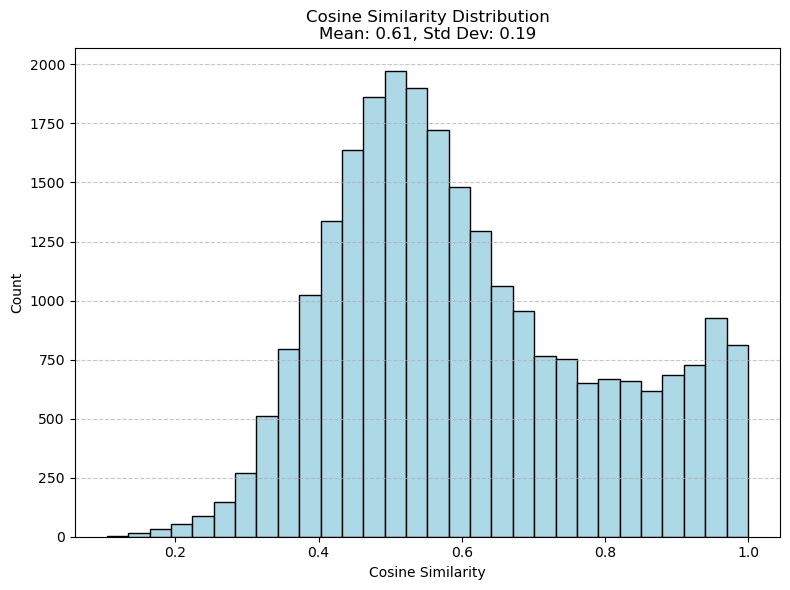

Average Cosine similarity: 0.6073332611992583
Standard deviation of Cosine similarity: 0.18548016367205858


In [29]:
lv_similarities = []
lv_pairs = list()

for i in range(svd.components_.shape[1]):
        for j in range(i + 1, (svd.components_.shape[1])):
                lv_pairs.append((svd.components_[:,i], svd.components_[:,j]))

for lv1, lv2 in lv_pairs:
        lv_sim = compute_cos_sim(lv1, lv2)
        lv_similarities.append(lv_sim)

lv_mean_similarity = np.mean(lv_similarities)
lv_std_dev_similarity = np.std(lv_similarities)

plt.figure(figsize=(8, 6))
plt.hist(lv_similarities, bins=30, color='lightblue', edgecolor='black')
plt.title(f"Cosine Similarity Distribution\nMean: {lv_mean_similarity:.2f}, Std Dev: {lv_std_dev_similarity:.2f}")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Average Cosine similarity:", lv_mean_similarity)
print("Standard deviation of Cosine similarity:", lv_std_dev_similarity)

#### Fingerprint Similarity vs Latent Vector Similarity


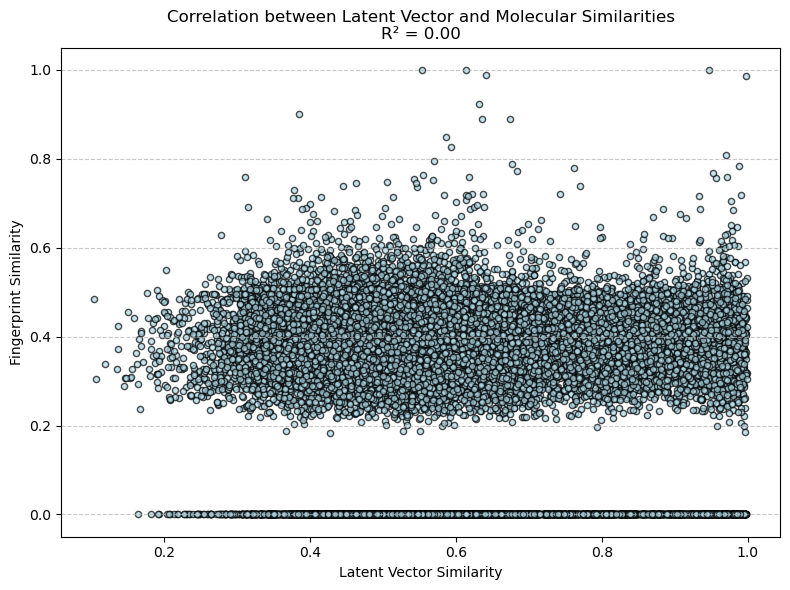

In [30]:
from scipy.stats import pearsonr

r_value, _ = pearsonr(lv_similarities, fp_similarities)
r_squared = r_value**2

plt.figure(figsize=(8, 6))
plt.scatter(lv_similarities, fp_similarities, alpha=0.7, s=20, color='lightblue', edgecolor='black')
plt.title(f"Correlation between Latent Vector and Molecular Similarities\nR² = {r_squared:.2f}")
plt.xlabel("Latent Vector Similarity")
plt.ylabel("Fingerprint Similarity")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Cell Line similarities